In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import glob
import numpy as np
import xarray as xr
import downscale as down

import pandas as pd
import geopandas as gpd
import scipy.stats as stats

from scipy.stats import weibull_min

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

## Downscaling for IMERG 3h in Veneto region Manual

In [2]:
name, yy_s, yy_e = 'Coast Level', 2001, 2016
# name, yy_s, yy_e = 'Low Level', 2001, 2013
# name, yy_s, yy_e = 'Medium Level', 2001, 2016
# name, yy_s, yy_e = 'High Level', 2001, 2022

print(f'Station   : {name}')
print(f'Start year: {yy_s}')
print(f'End year  : {yy_e}')

Station   : Coast Level
Start year: 2001
End year  : 2016


In [3]:
Veneto = gpd.read_file(os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson'))

In [4]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0 # Earth radius in kilometers
    
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

In [249]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','3_hour',f'IMERG_Veneto_3h_2001_01_01_2023_12_31.nc')
DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

DATES = DATA['time'][:]

dset = np.array(DATA['PRE'])
dset[dset==np.nanmin(dset)]=0

DATA

<xarray.Dataset> Size: 449MB
Dimensions:  (time: 46752, lat: 30, lon: 40)
Coordinates:
  * time     (time) datetime64[ns] 374kB 2001-01-01 ... 2016-12-31T21:00:00
  * lat      (lat) float32 120B 44.05 44.15 44.25 44.35 ... 46.75 46.85 46.95
  * lon      (lon) float32 160B 10.05 10.15 10.25 10.35 ... 13.75 13.85 13.95
Data variables:
    PRE      (time, lat, lon) float64 449MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    description:  IMERG 3 hour data for Veneto region

In [6]:
PRE_daily = DATA.resample(time ='D').sum(dim='time', skipna=False)
DATES_daily = PRE_daily['time']

## Raingauge data

In [7]:
rain_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')
RAIN = pd.read_csv(os.path.join(rain_dir, 'QC_stations_coords_utm32.csv'), sep=';')

if name == 'Coast Level':
    Id_station = '338_RO_Co.csv'
elif name == 'Low Level':
    Id_station = '274_VR_Mo.csv'
elif name == 'Medium Level':
    Id_station = '343_BL_Fo.csv'
elif name == 'High Level':
    Id_station = '348_NP_Ro.csv'
else:
    print('ERROR: Id dont found')

print(f'{name} station')
CL_INFO = RAIN[RAIN['File_Name']==Id_station]

CL_RAIN = pd.read_csv(os.path.join(rain_dir, 'Dati_QC_30min', CL_INFO['File_Name'].values[0]), sep=';')
CL_RAIN['dataora'] = pd.to_datetime(CL_RAIN['dataora'])
CL_RAIN['yy'] = pd.to_datetime(CL_RAIN['dataora']).dt.year
CL_RAIN['mm'] = pd.to_datetime(CL_RAIN['dataora']).dt.month
CL_RAIN['dd'] = pd.to_datetime(CL_RAIN['dataora']).dt.day
CL_RAIN['hh'] = pd.to_datetime(CL_RAIN['dataora']).dt.hour
CL_RAIN['mm'] = pd.to_datetime(CL_RAIN['dataora']).dt.minute

CL_RAIN[CL_RAIN['valore']>200] = 0

CL_RAIN.tail(3)

Coast Level station


,dataora,valore,qualita,yy,mm,dd,hh
528403,2017-11-30 10:00:00,0.0,1.0,2017,0,30,10
528404,2017-11-30 10:30:00,0.0,1.0,2017,30,30,10
528405,2017-11-30 11:00:00,0.0,1.0,2017,0,30,11


In [8]:
CL_RAIN['dataora'] = pd.to_datetime(CL_RAIN['dataora'])
CL_RAIN.set_index('dataora', inplace=True)

In [426]:
CL_RAIN = CL_RAIN[(CL_RAIN['yy']>=yy_s)&(CL_RAIN['yy']<=yy_e)]

# OBS 3 hours
rainfall_3h_accumulated = CL_RAIN['valore'].resample('3H').sum()
OBS_3h = pd.DataFrame({
        'PRE':rainfall_3h_accumulated.values, 
            'TIME':pd.to_datetime(rainfall_3h_accumulated.index)
                    })

# OBS 6 hours
rainfall_6h_accumulated = CL_RAIN['valore'].resample('6H').sum()
OBS_6h = pd.DataFrame({
            'PRE':rainfall_6h_accumulated.values, 
            'TIME':pd.to_datetime(rainfall_6h_accumulated.index)
                    })

# OBS 1 day
rainfall_1dy_accumulated = CL_RAIN['valore'].resample('1D').sum()
OBS_1dy = pd.DataFrame({
            'PRE':rainfall_1dy_accumulated.values, 
            'TIME':pd.to_datetime(rainfall_1dy_accumulated.index)
                    })

In [427]:
# Fit yearly weibull for 3h OBS time
OBS_3h_xr = xr.DataArray(OBS_3h['PRE'].values, 
                coords={'time':OBS_3h['TIME'].values}, 
                dims=('time'))
NCW_3h, YEARS_3h = down.fit_yearly_weibull(OBS_3h_xr, thresh=1, maxmiss=36)

# Fit yearly weibull for 6h OBS time
OBS_6h_xr = xr.DataArray(OBS_6h['PRE'].values, 
                coords={'time':OBS_6h['TIME'].values}, 
                dims=('time'))
NCW_6h, YEARS_6h = down.fit_yearly_weibull(OBS_6h_xr, thresh=1, maxmiss=36)

# Fit yearly weibull for 1dy OBS time
OBS_1dy_xr = xr.DataArray(OBS_1dy['PRE'].values, 
                coords={'time':OBS_1dy['TIME'].values}, 
                dims=('time'))
NCW_1dy, YEARS_1dy = down.fit_yearly_weibull(OBS_1dy_xr, thresh=1, maxmiss=36)

## Raingauge Number of wet times - manual test

In [433]:
# Manual test for number of observation greather than threshold
print('Relative Number of wet times for 2001')
print()

sample_3h = OBS_3h_xr.sel(time=str(2001))
excesses = sample_3h[sample_3h > 1]
Ni = np.size(excesses)
print(f'3h N: {Ni} and total times: {len(sample_3h)}')

sample_6h = OBS_6h_xr.sel(time=str(2001))
excesses = sample_6h[sample_6h > 1]
Ni = np.size(excesses)
print(f'6h N: {Ni} and total times: {len(sample_3h)}')

sample_1dy = OBS_1dy_xr.sel(time=str(2001))
excesses = sample_1dy[sample_1dy > 1]
Ni = np.size(excesses)
print(f'1d N: {Ni} and total times: {len(sample_1dy)}')

Relative Number of wet times for 2001

3h N: 119 and total times: 2920
6h N: 100 and total times: 2920
1d N: 78 and total times: 365


Text(0.5, 0, 'Year')

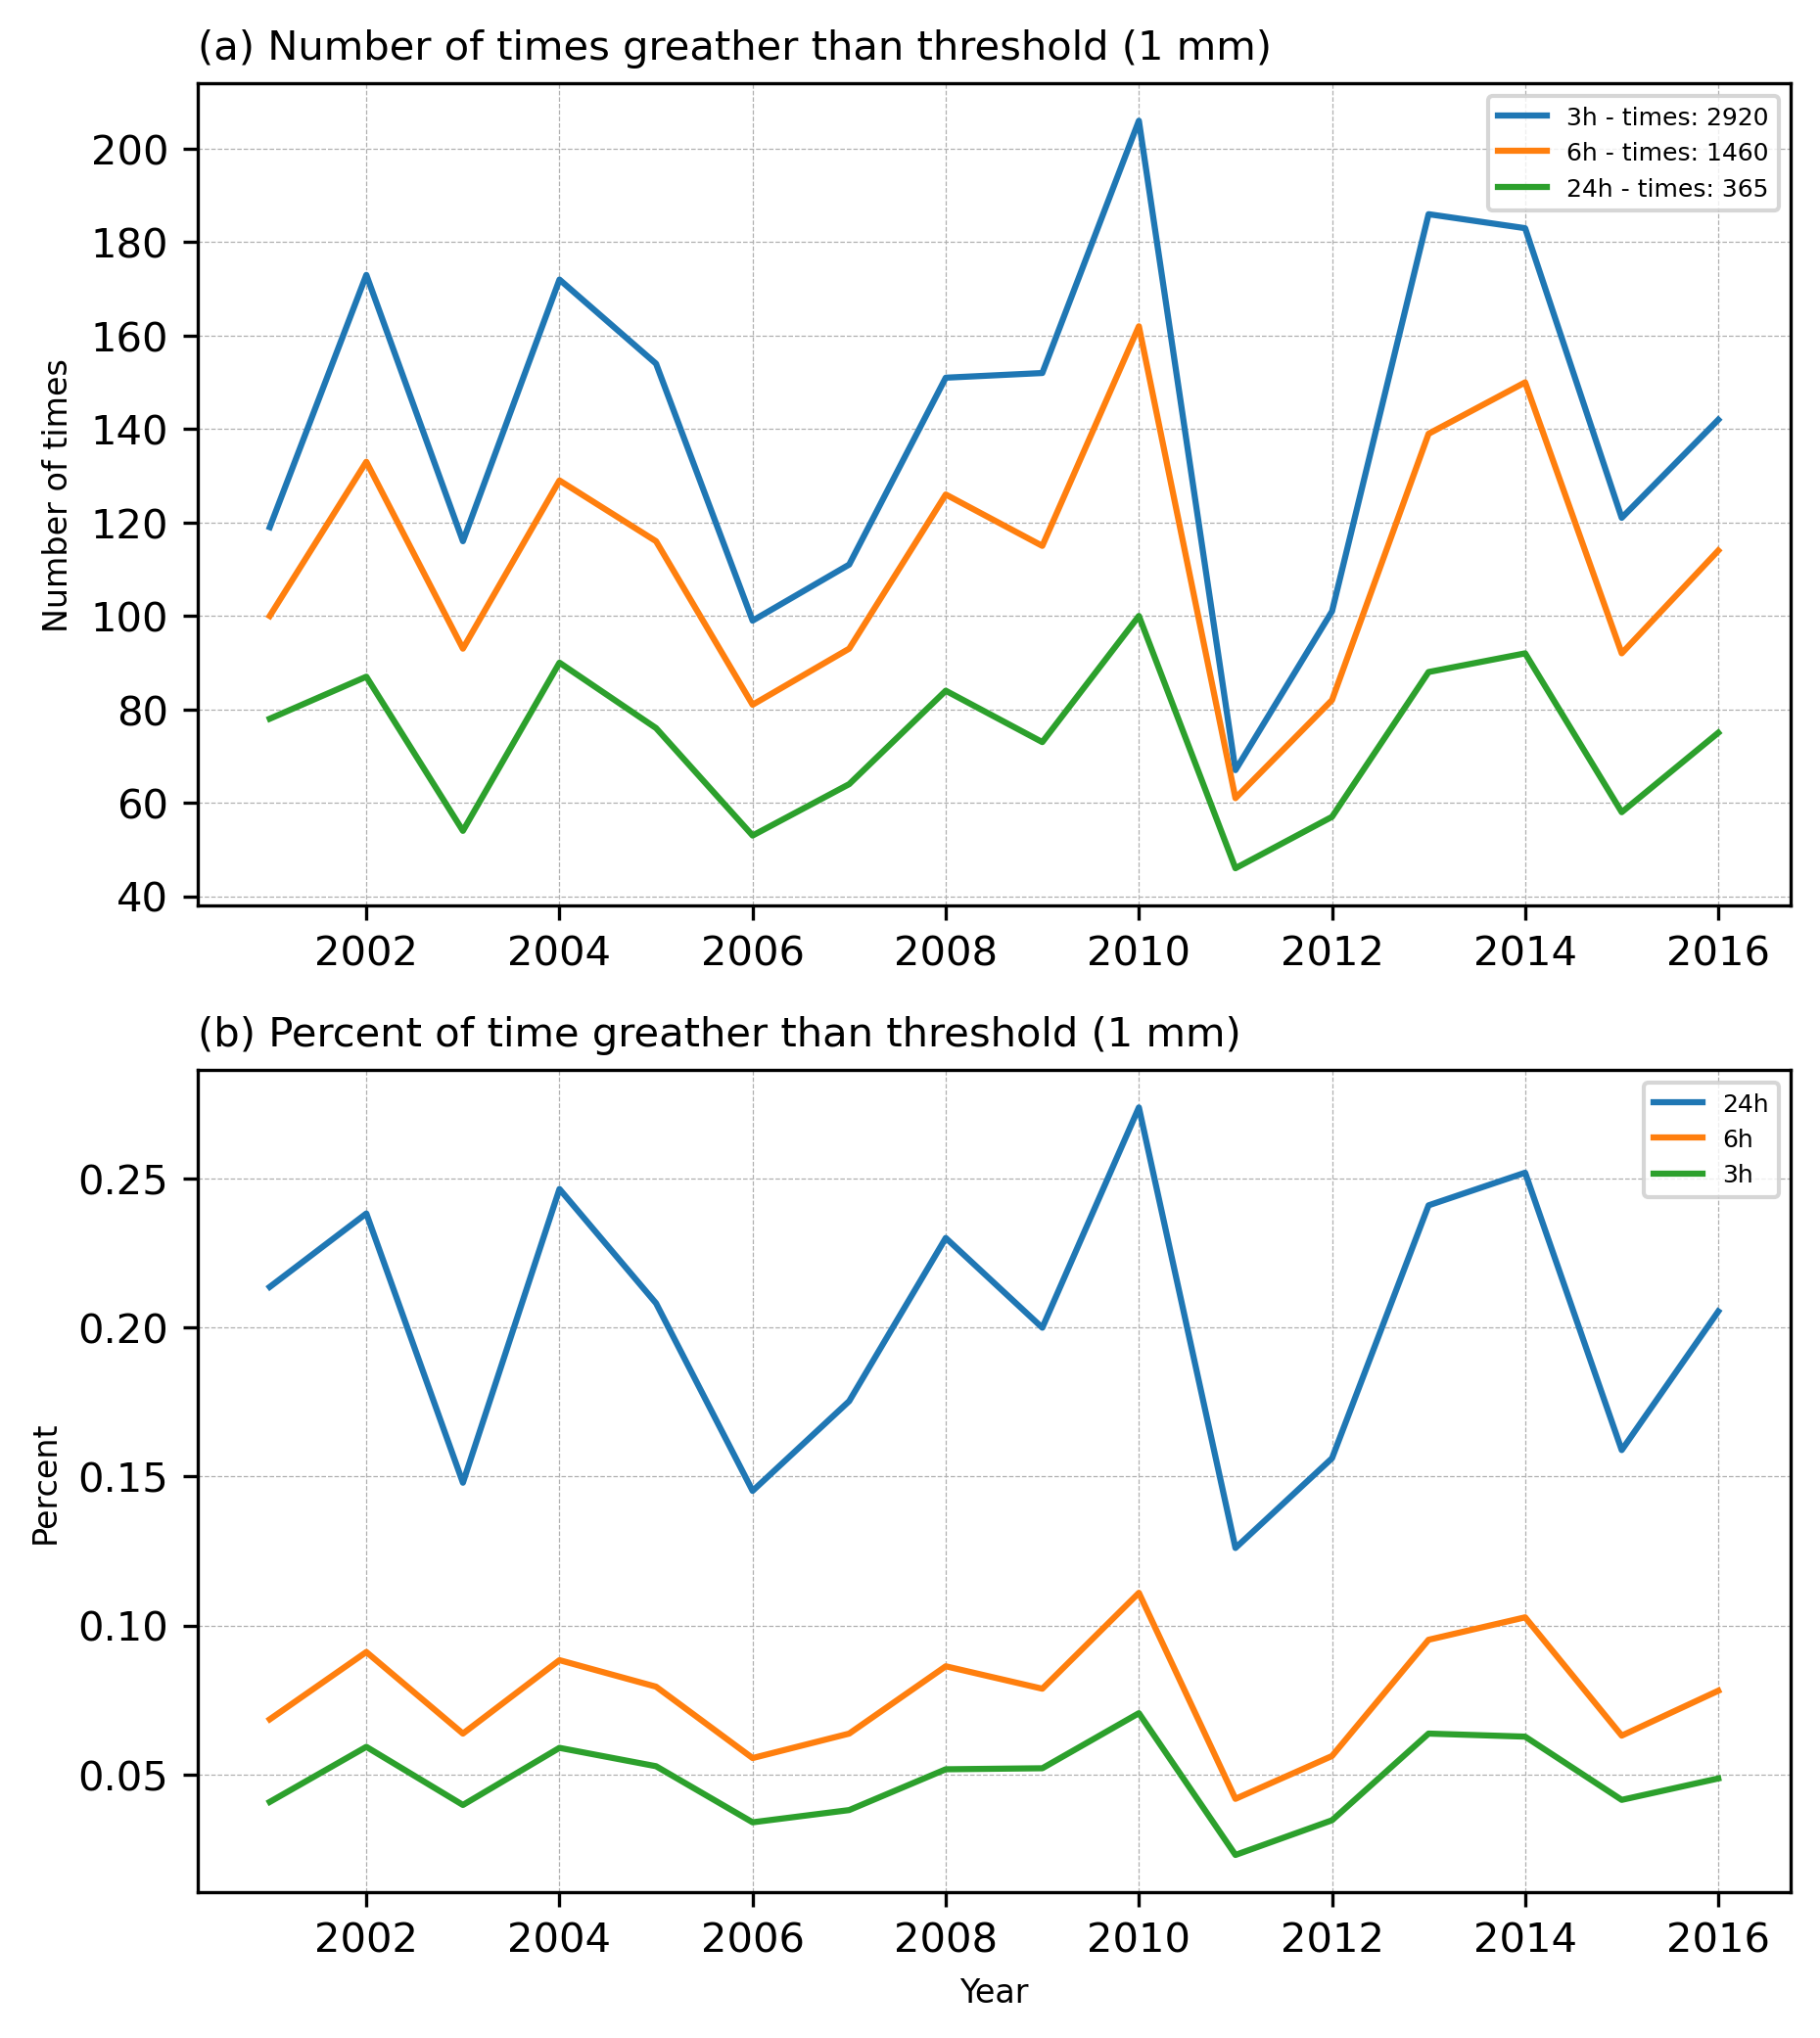

In [440]:
fig = plt.figure(figsize=(7,8),dpi=300)
gs = gridspec.GridSpec(2,1)

# =================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(YEARS_3h, NCW_3h[:,0], label=f'3h - times: {len(sample_3h)}')
ax1.plot(YEARS_6h, NCW_6h[:,0], label=f'6h - times: {len(sample_6h)}')
ax1.plot(YEARS_1dy, NCW_1dy[:,0], label=f'24h - times: {len(sample_1dy)}')
ax1.legend(fontsize=6)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(a) Number of times greather than threshold (1 mm)',loc='left',fontsize=10)
ax1.set_ylabel('Number of times', fontsize=8)

# =================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.plot(YEARS_1dy, NCW_1dy[:,0]/len(sample_1dy), label='24h')
ax1.plot(YEARS_6h, NCW_6h[:,0]/len(sample_6h), label='6h')
ax1.plot(YEARS_3h, NCW_3h[:,0]/len(sample_3h), label='3h')
ax1.legend(fontsize=6)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(b) Percent of time greather than threshold (1 mm)',loc='left',fontsize=10)
ax1.set_ylabel('Percent', fontsize=8)
ax1.set_xlabel('Year', fontsize=8)

Text(0.5, 0, 'Year')

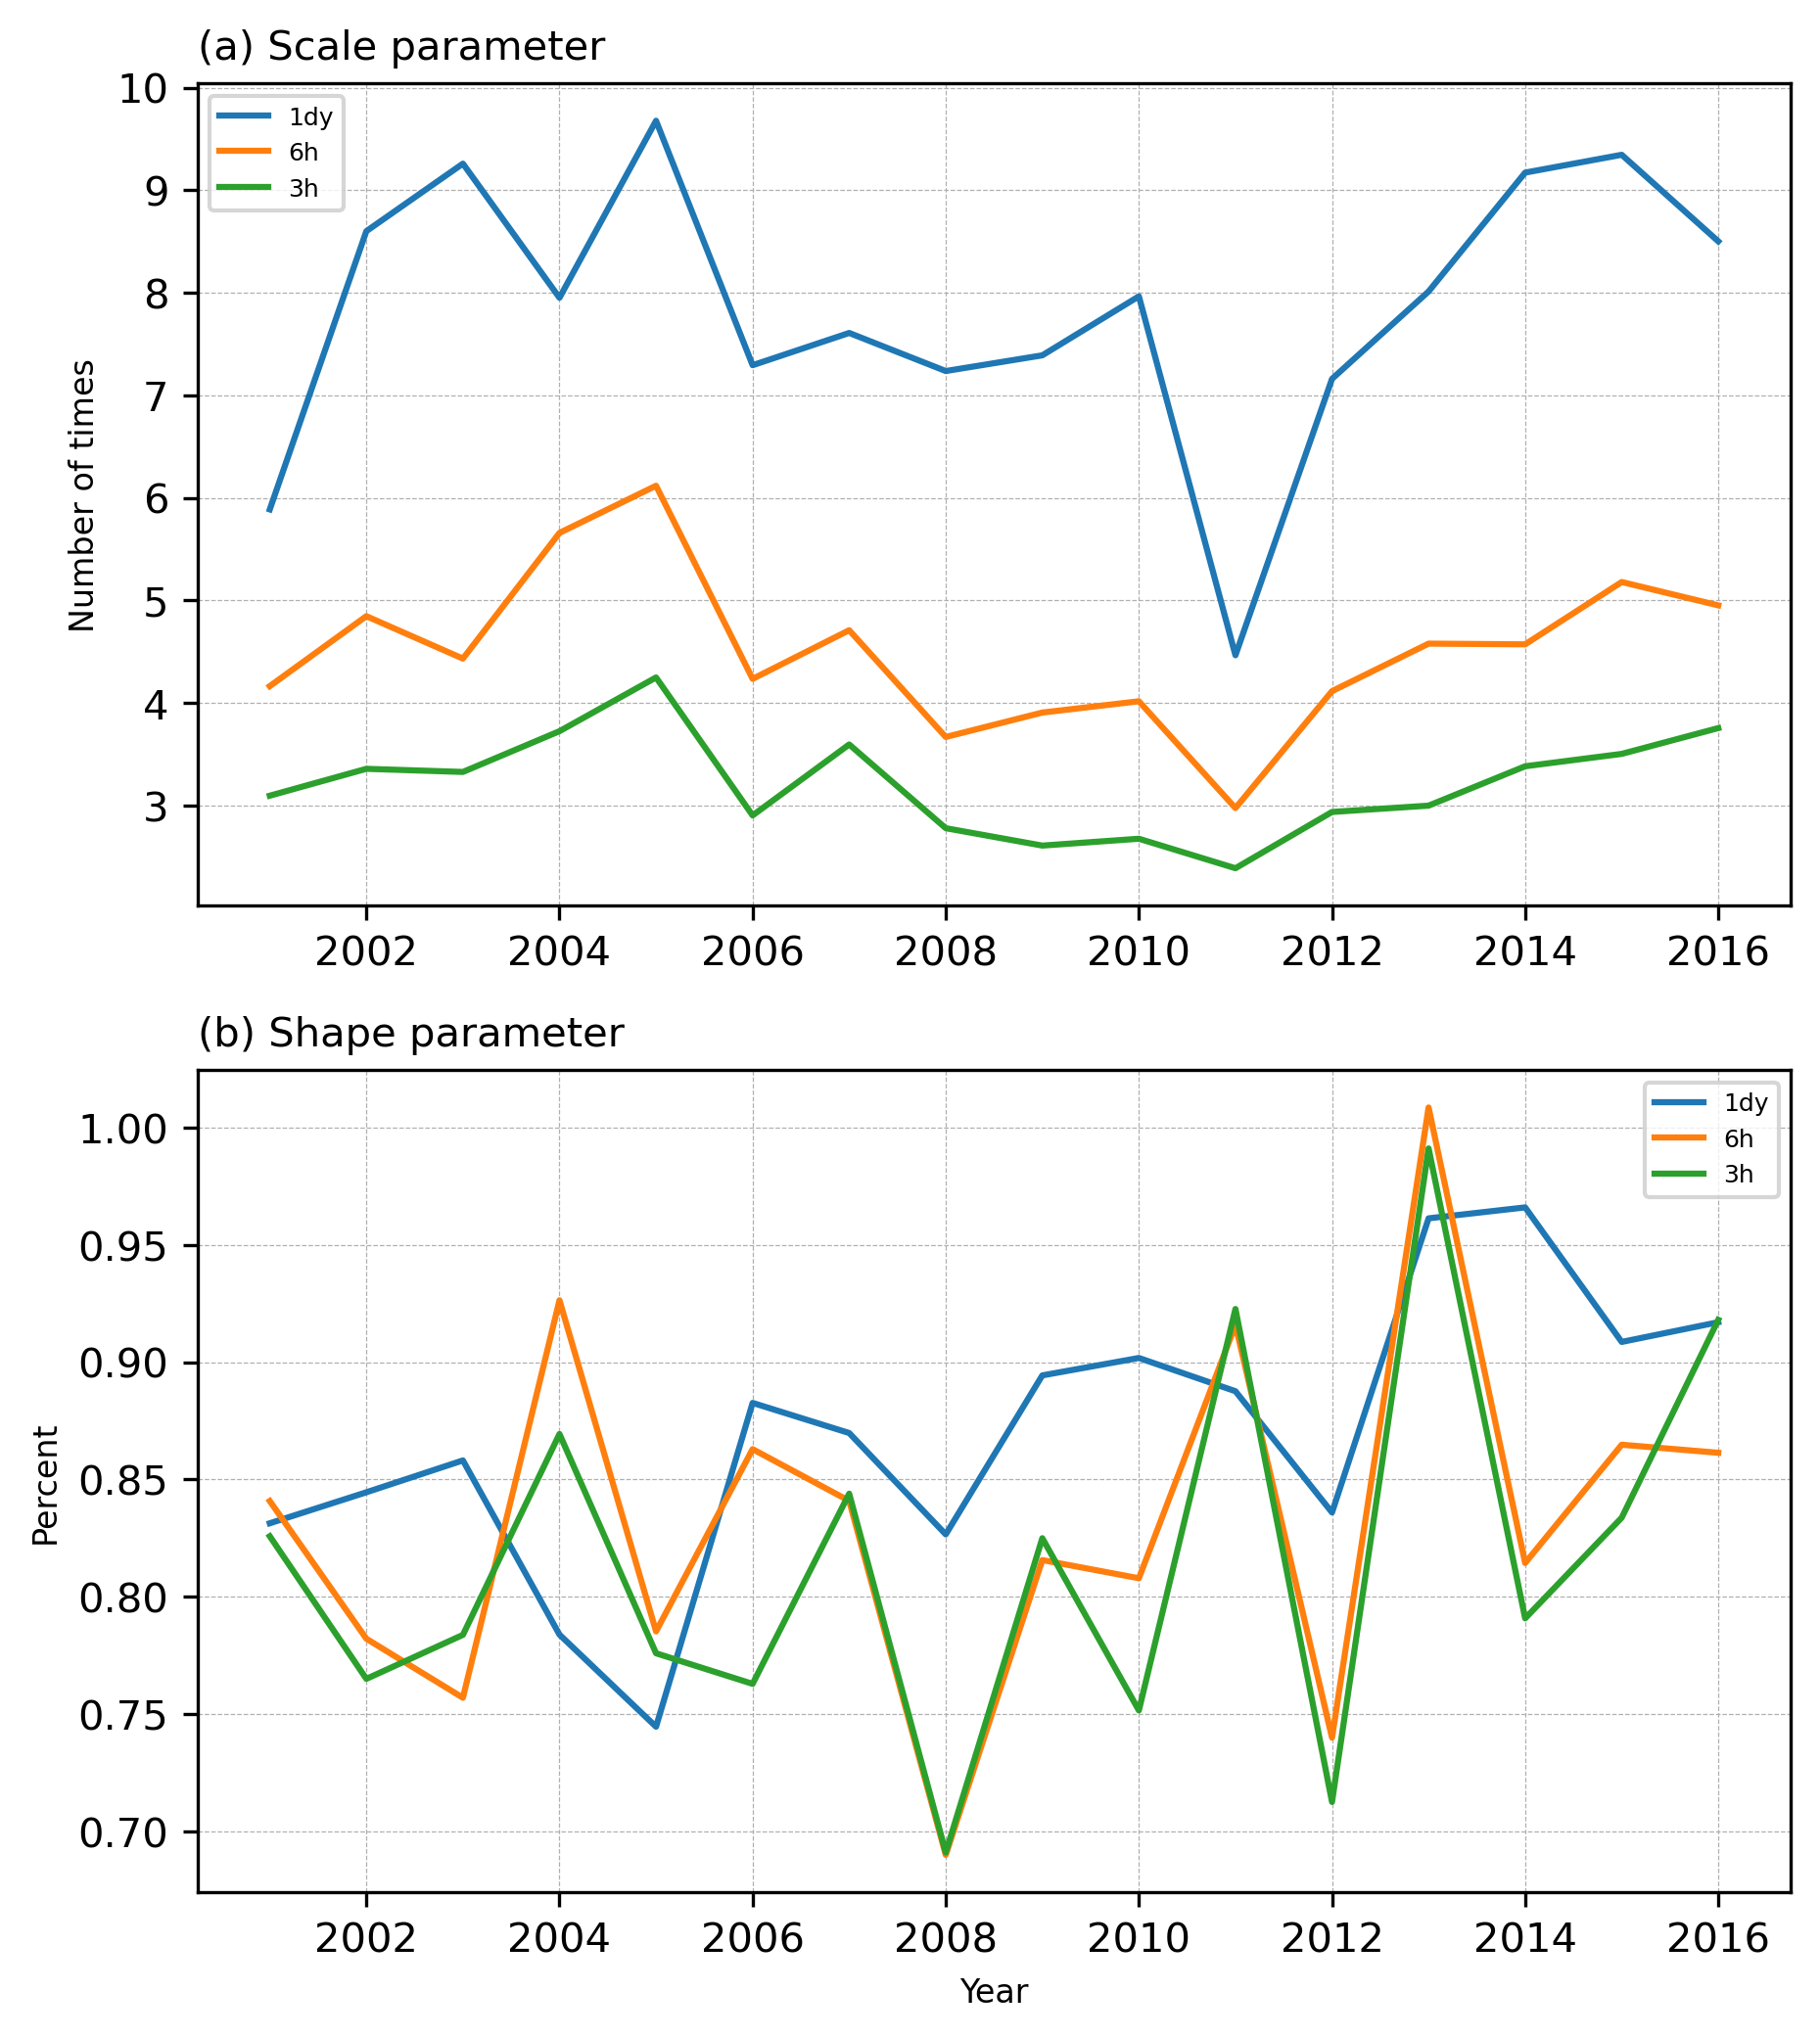

In [441]:
fig = plt.figure(figsize=(7,8),dpi=300)
gs = gridspec.GridSpec(2,1)

# =================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(YEARS_1dy, NCW_1dy[:,1], label='1dy')
ax1.plot(YEARS_6h, NCW_6h[:,1], label='6h')
ax1.plot(YEARS_3h, NCW_3h[:,1], label='3h')
ax1.legend(fontsize=6)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(a) Scale parameter',loc='left',fontsize=10)
ax1.set_ylabel('Number of times', fontsize=8)

# =================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.plot(YEARS_1dy, NCW_1dy[:,2], label='1dy')
ax1.plot(YEARS_6h, NCW_6h[:,2], label='6h')
ax1.plot(YEARS_3h, NCW_3h[:,2], label='3h')
ax1.legend(fontsize=6)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(b) Shape parameter',loc='left',fontsize=10)
ax1.set_ylabel('Percent', fontsize=8)
ax1.set_xlabel('Year', fontsize=8)

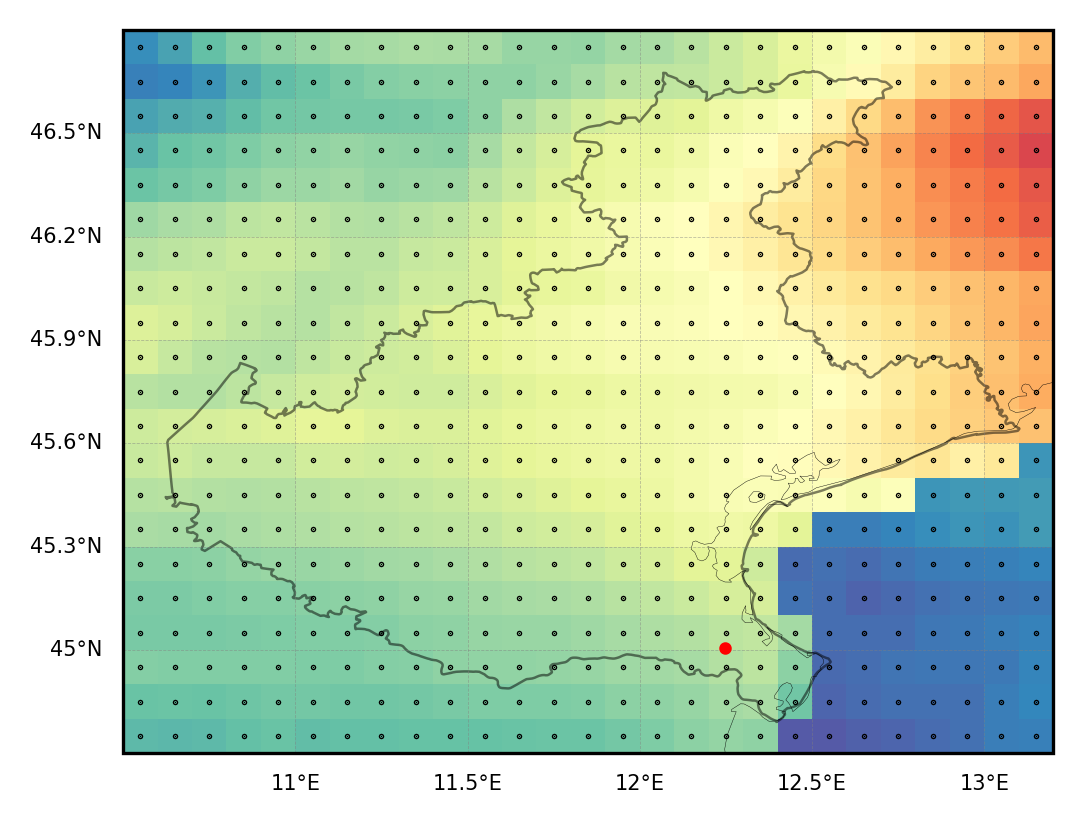

In [11]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,4),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(dset,axis=0),cmap=cmap)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o')

ax1.scatter(CL_INFO['Lon'], CL_INFO['Lat'], s=4, c='r', zorder=10)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

In [12]:
RAIN_lat = CL_INFO['Lat'].values[0]
RAIN_lon = CL_INFO['Lon'].values[0]

In [13]:
distances = haversine(lat2d, lon2d, RAIN_lat, RAIN_lon)
min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

clat = lats[min_index[0]]
clon = lons[min_index[1]]

IMERG_ML = dset[:,min_index[0],min_index[1]]

print(f"Nearest IMERG lat: {clat}")
print(f'Station lat       : {RAIN_lat}')
print()
print(f"Nearest IMERG lon: {clon}")
print(f'Station lon       : {RAIN_lon}')

Nearest IMERG lat: 45.04999923706055
Station lat       : 45.00466666

Nearest IMERG lon: 12.25
Station lon       : 12.24819444


## Compare weibull parameters between IMERG close pixel with Raingauge

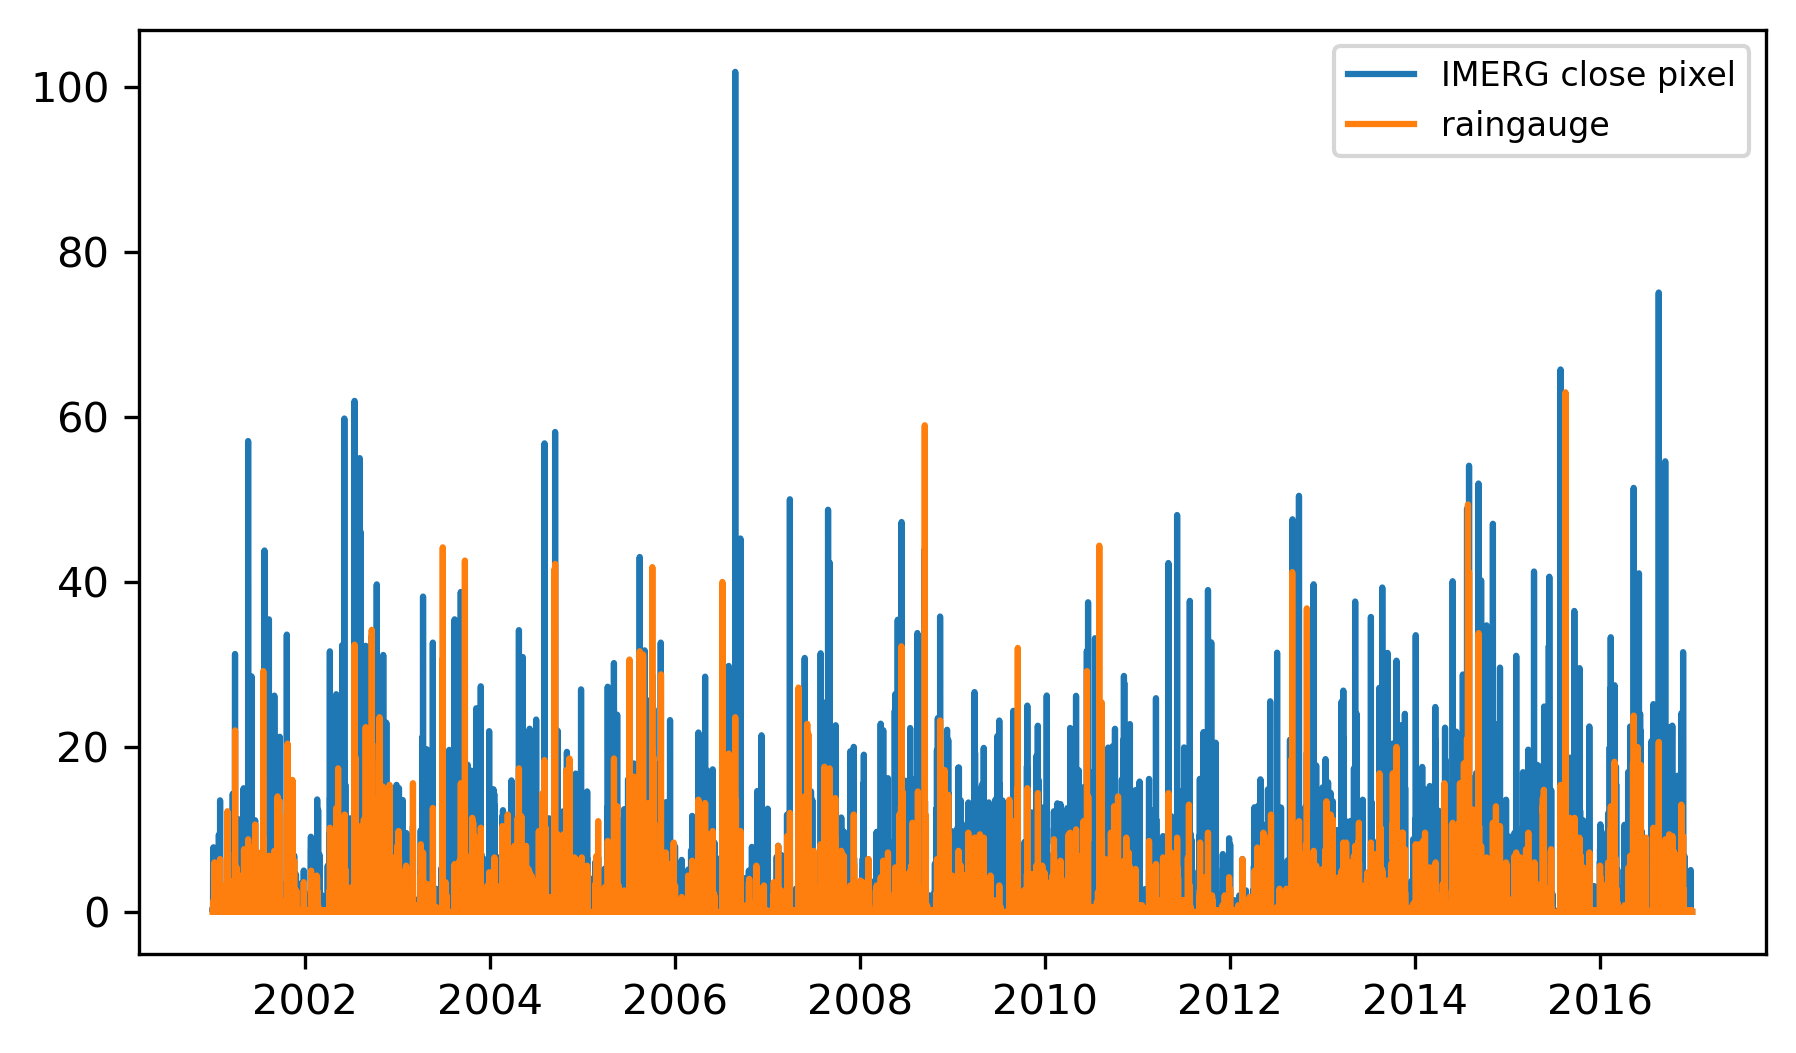

In [499]:
fig = plt.figure(figsize=(7,4),dpi=300)
gs = gridspec.GridSpec(1,1)

# =================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(OBS_3h['TIME'].values, IMERG_ML, label='IMERG close pixel')
ax1.plot(OBS_3h['TIME'].values, OBS_3h['PRE'].values, label='raingauge')
ax1.legend(fontsize=8)

In [500]:
# Fit yearly weibull for 3h OBS time
IMERG_ML_xr = xr.DataArray(IMERG_ML, 
                coords={'time':OBS_3h['TIME'].values}, 
                dims=('time'))
NCW_IMERG, YEARS_IMERG = down.fit_yearly_weibull(IMERG_ML_xr, thresh=1, maxmiss=36)

Text(0, 0.5, 'Number of times')

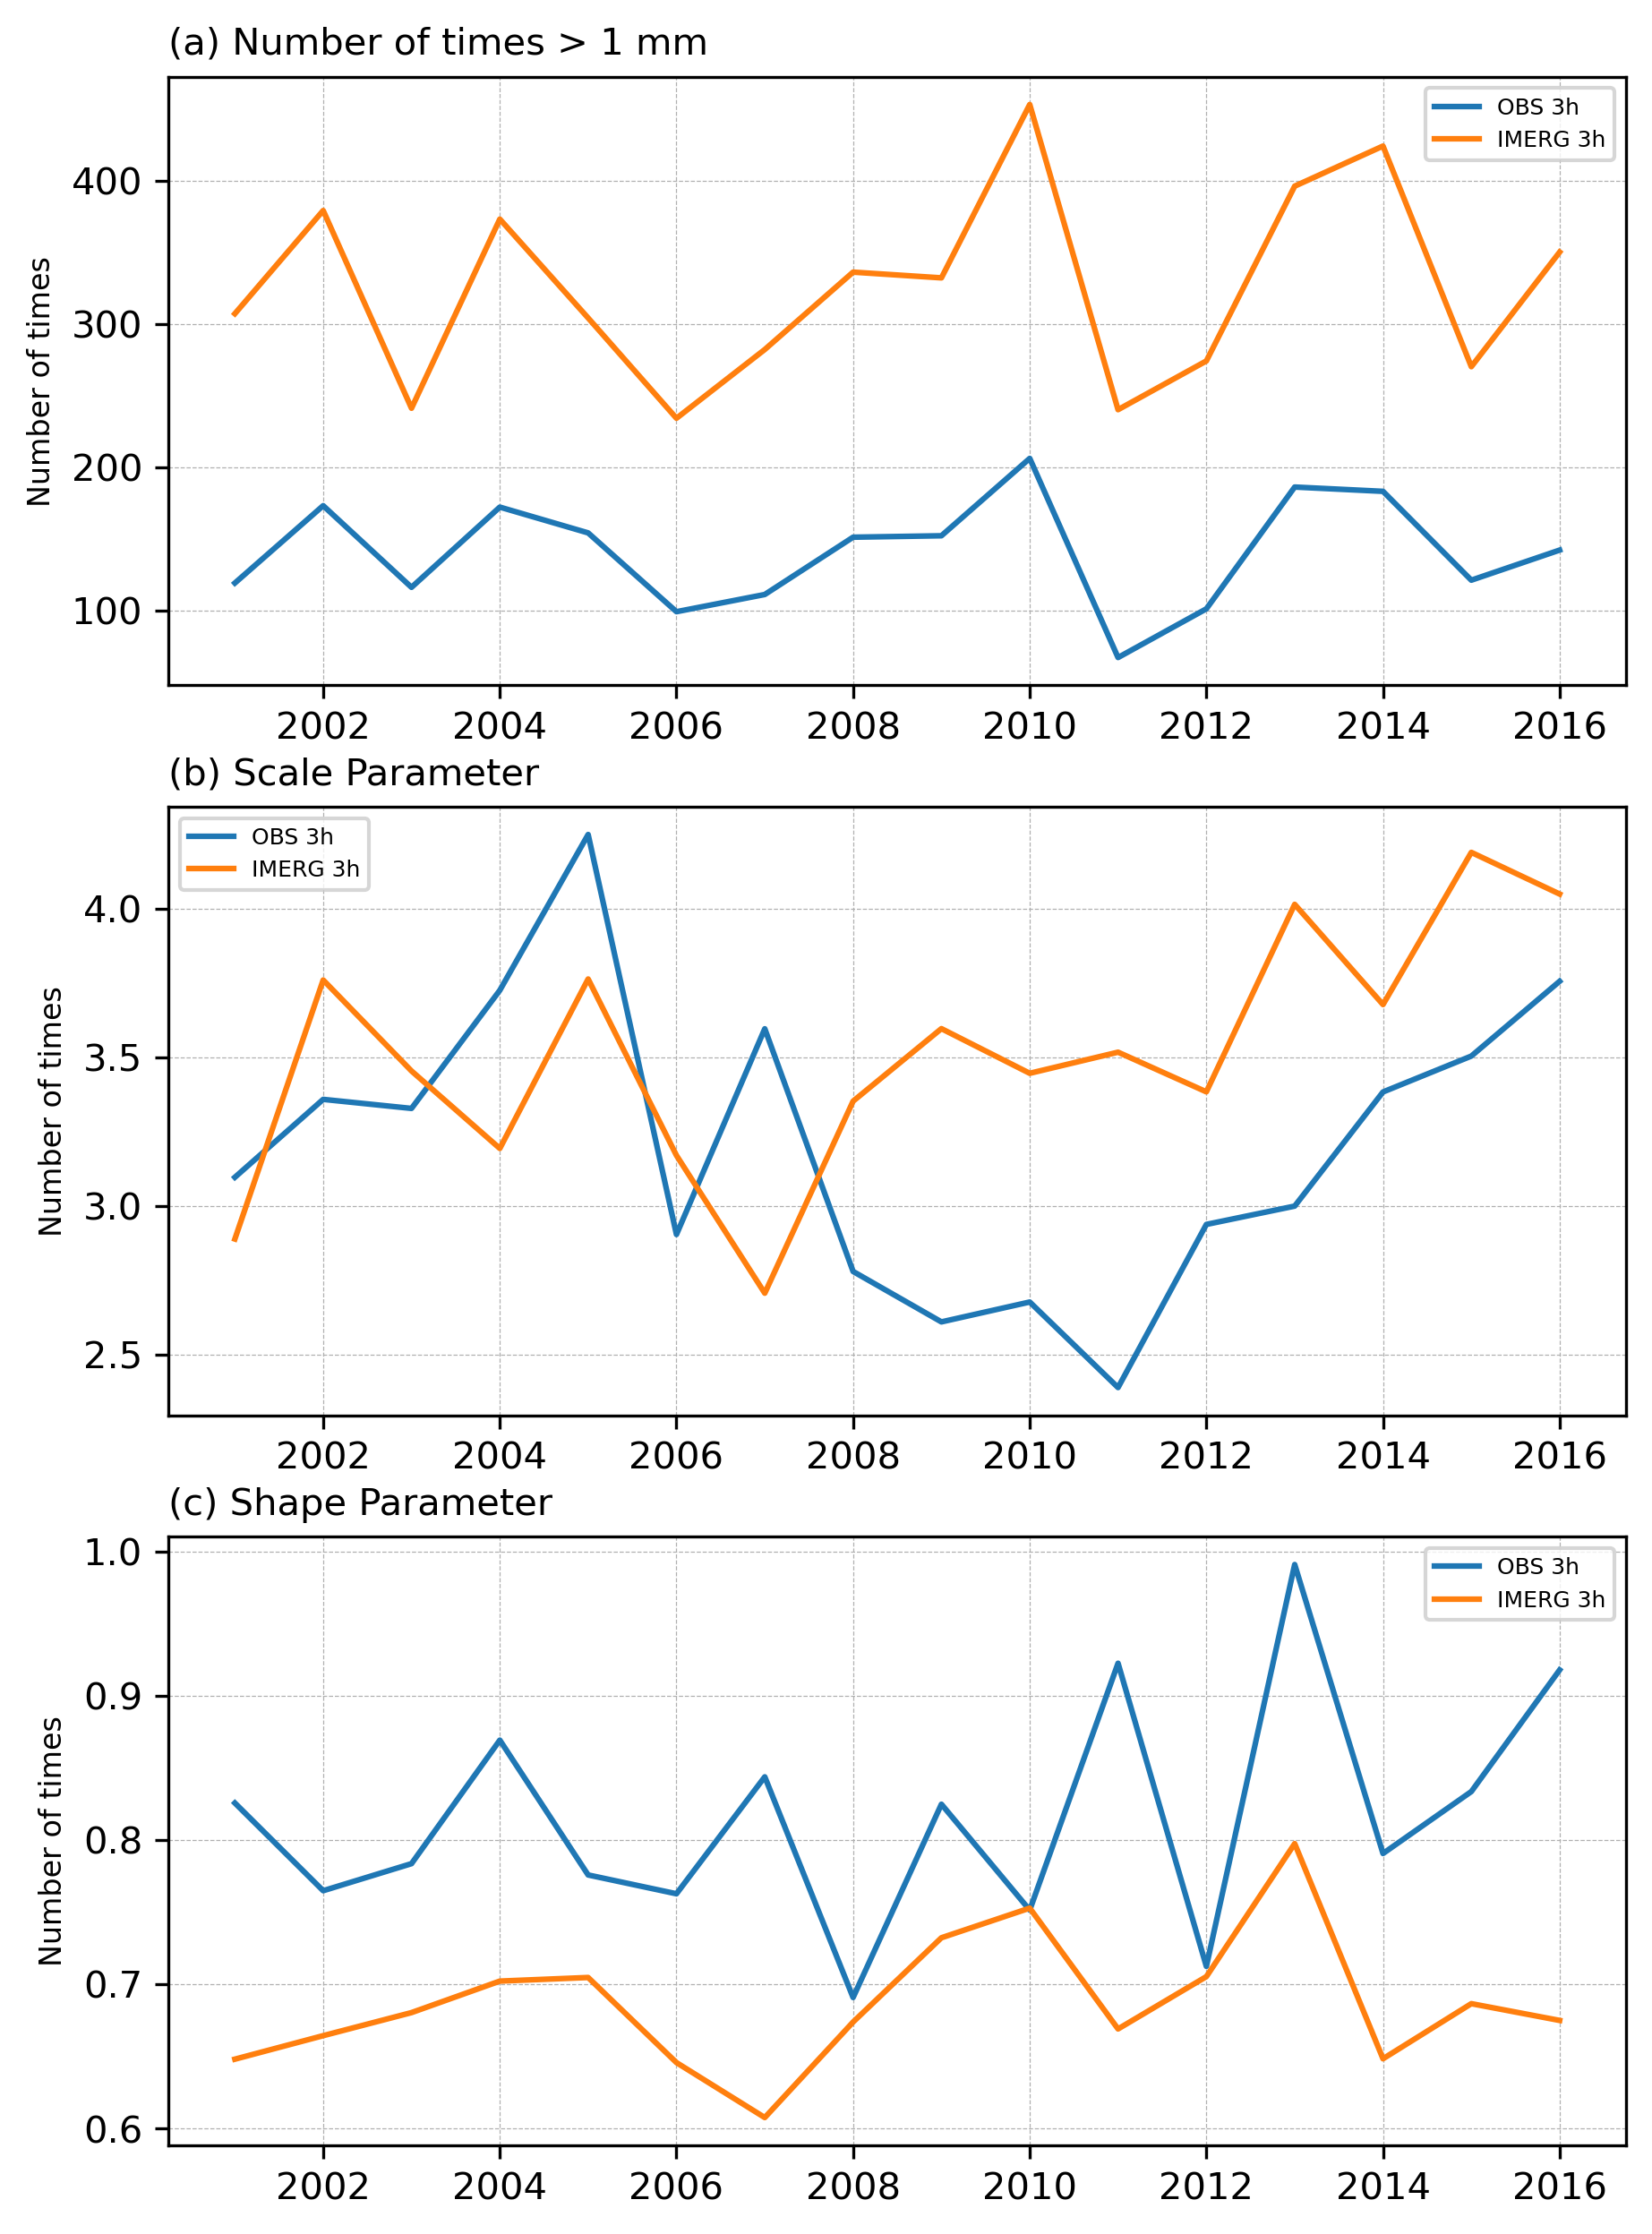

In [503]:
fig = plt.figure(figsize=(7,10),dpi=300)
gs = gridspec.GridSpec(3,1)

# =================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(YEARS_3h, NCW_3h[:,0], label=f'OBS 3h')
ax1.plot(YEARS_IMERG, NCW_IMERG[:,0], label=f'IMERG 3h')
ax1.legend(fontsize=6)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(a) Number of times > 1 mm',loc='left',fontsize=10)
ax1.set_ylabel('Number of times', fontsize=8)

# =================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.plot(YEARS_3h, NCW_3h[:,1], label=f'OBS 3h')
ax1.plot(YEARS_IMERG, NCW_IMERG[:,1], label=f'IMERG 3h')
ax1.legend(fontsize=6)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(b) Scale Parameter',loc='left',fontsize=10)
ax1.set_ylabel('Number of times', fontsize=8)

# =================================================================
ax1 = plt.subplot(gs[2, 0])
ax1.plot(YEARS_3h, NCW_3h[:,2], label=f'OBS 3h')
ax1.plot(YEARS_IMERG, NCW_IMERG[:,2], label=f'IMERG 3h')
ax1.legend(fontsize=6)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(c) Shape Parameter',loc='left',fontsize=10)
ax1.set_ylabel('Number of times', fontsize=8)

In [218]:
npix = 3
# buffer = 0.5*npix*dx
buffer = 0.5*npix*0.1

thresh = 1

In [252]:
# Original data 3h time resolution
test = np.swapaxes(dset, 0, 2)
xrs0 = xr.DataArray(test,  coords={'lon':lons, 'lat':lats, 'time':DATES.data}, dims=('lon', 'lat', 'time'))
xrs = xrs0.where(xrs0 >= -0.001)

In [253]:
eps = 1e-4 # to make sure to include boundaires -> add an eps buffer
solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))

In [256]:
# Box 3h time resolution
box_3h = xrs.where(bcond, drop = True).load()
box_3h.shape

(3, 3, 46752)

In [260]:
# daily time resolution
xdaily0 = box_3h.resample(time ='{}h'.format(24)).sum(dim='time', skipna=False)
xdaily = xdaily0.dropna(dim='time', how='any')

In [258]:
tsc = box_3h.loc[dict(lat = clat, lon = clon)]
c_excesses = tsc.values[tsc.values > thresh] - thresh

In [442]:
# daily time resolution weibull fit
NCW = down.wei_fit(c_excesses)
pws = NCW[0]/box_3h.shape[2]
Ns = int(np.floor(pws*365.25))
Cs = NCW[1]
Ws = NCW[2]

## Start Taylor Hypotesis

In [243]:
L1 = 10
L0 = 0.0001

dt = 3 # time scale of the precipitation product [HOURS] (default 3 hours)

target_x = 0.0001 # subgrid spatial scale we want pwet at [km](default 0.0001 km)
target_t = 24 # target time scale, in [HOURS] (default 24 hours)

origin_x = 10 # linear spatial scale of origin gridded prcp [km] (default 25)
origin_t = 24 # time scale of origin gridded pecip [HOURS] (default 24 hours)
ninterp = 2000 # number of interpolation in time dimension

cube1size = 3 # lateral size of cube used to decide among how many single pixel average at smallest scale
tmax = 48 # maximum time scale of integration [HOURS]

acf='mar'

In [226]:
smax = box_3h.shape[0] # max spatial scale
smax = 3
tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20,
                                    24, 36, 48, 96])*dt
tscales = tscales[tscales < tmax + 0.001]
xscales = np.arange(1, smax+1)
ntscales = np.size(tscales)
nsscales = np.size(xscales)
pwets = np.zeros((ntscales, nsscales))

In [227]:
def wetfrac(array, thresh):
    return np.size(array[array > thresh])/np.size(array)

In [228]:
for it, st in enumerate(tscales):
    datamat = box_3h.resample(time='{}h'.format(st)).sum(
                                dim='time', skipna = False)

    for ix, sx in enumerate(xscales):

        if sx == 1: # pixel scale

            toskip = smax - cube1size
            if toskip % 2 == 0:
                buffer1 = toskip // 2
                buffer2 = toskip // 2
            else:
                buffer1 = toskip // 2
                buffer2 = buffer1 + 1

            if buffer2 > 0:
                aggt1 = datamat[buffer1:-buffer2, buffer1:-buffer2, :]
            else:
                aggt1 = datamat[buffer1:, buffer1:, :]

            # print('shape of p1 array = ', aggt1.shape)

            p1 = np.zeros((aggt1.shape[0], aggt1.shape[1]))


            for x in range(aggt1.shape[0]):
                for y in range(aggt1.shape[1]):
                    # print('Hello1')
                    p1[x, y] = wetfrac(aggt1[x, y, :].dropna(
                                        dim='time', how='any'), thresh)
            pwets[it, ix] = np.mean(p1)


        elif sx == smax: # largest scale: simple average
            pwets[it, ix] = wetfrac( datamat.mean(dim=('lat', 'lon'),
                            skipna = False).dropna(dim='time', how='any'),
                            thresh)

        else: # intermediate scales
            c1 = np.zeros(4)
            c1[0] = wetfrac(datamat[:sx, :sx, :].mean(dim=('lat', 'lon'),
                            skipna=False).dropna(dim='time', how='any'),
                            thresh)
            c1[1] = wetfrac(datamat[-sx:, :sx, :].mean(dim=('lat', 'lon'),
                            skipna=False).dropna(dim='time', how='any'),
                            thresh)
            c1[2] = wetfrac(datamat[:sx, :sx, :].mean(dim=('lat', 'lon'),
                            skipna=False).dropna(dim='time', how='any'),
                            thresh)
            c1[3] = wetfrac(datamat[-sx:, :sx, :].mean(dim=('lat', 'lon'),
                            skipna=False).dropna(dim='time', how='any'),
                            thresh)
            pwets[it, ix] = np.mean(c1)

In [229]:
xscales_km = xscales*L1
ntscales = np.size(tscales)
nxscales = np.size(xscales)
tscales_int = np.linspace(np.min(tscales), np.max(tscales), ninterp)
pwmat_int = np.zeros((ninterp, nxscales))

for col in range(nxscales):
    pwmat_int[:, col] = np.interp(tscales_int, tscales, pwets[:, col])

In [230]:
pw_min = np.min(pwets)
pw_max = np.max(pwets)
mypw = np.linspace(pw_min, pw_max, ninterp)

In [231]:
myU = np.zeros(ninterp)   # initialize linear slope
myX0 = np.zeros(ninterp)  # initialize linear intercept
myindices = np.zeros((ninterp, nxscales), dtype = int)

In [232]:
for ii in range(ninterp):
    Tvec = np.zeros(nxscales)
    for jj in range(nxscales):
        myindices[ii,jj] = np.argmin(np.abs(pwmat_int[:, jj] - mypw[ii]))
        # tvec[ii,jj] = tscales_int[myindices[ii,jj]]
        Tvec[jj] = tscales_int[myindices[ii,jj]]
    warnings.simplefilter('ignore', np.RankWarning)
    res = np.polyfit(Tvec[:2], xscales_km[:2], 1)
    myU[ii] = res[0]
    myX0[ii] = res[1]

In [233]:
min_index = myindices.min(axis=1)
max_index = myindices.max(axis=1)
col_to_keep = np.logical_and(min_index > 0, max_index < ninterp-1)
mypw2 = mypw[col_to_keep]
U = myU[col_to_keep]
X0 = myX0[col_to_keep]

In [234]:
dthat = (target_x - X0) / U # compute time scale that would give me pwet
deltat = np.abs(dthat - target_t)
opt_deltat = np.min(deltat)
max_dt = 0.5 # half hour accuracy should suffice?
# set a TOLL value to check we are not too far away from the real deltat
if opt_deltat > max_dt:
    print('Taylor_Beta WARNING: not enough accuracy!')
    print('the time resolution of the coarse data might not be enough!')
    print('or try to increase the value of interp')
best_index = np.argmin(deltat)  # best prediction of 24 hour interval
pwet_target = mypw2[best_index]

In [235]:
pos_xmin = np.argmin(np.abs(origin_x - xscales_km))
pos_tmin = np.argmin(np.abs(origin_t - tscales_int))
pwet_origin = pwmat_int[pos_tmin, pos_xmin]
beta = pwet_origin / pwet_target

res = {}
res['beta'] = beta
beta

1.0173216261386124

Text(10, 24.5, 'Grid cell')

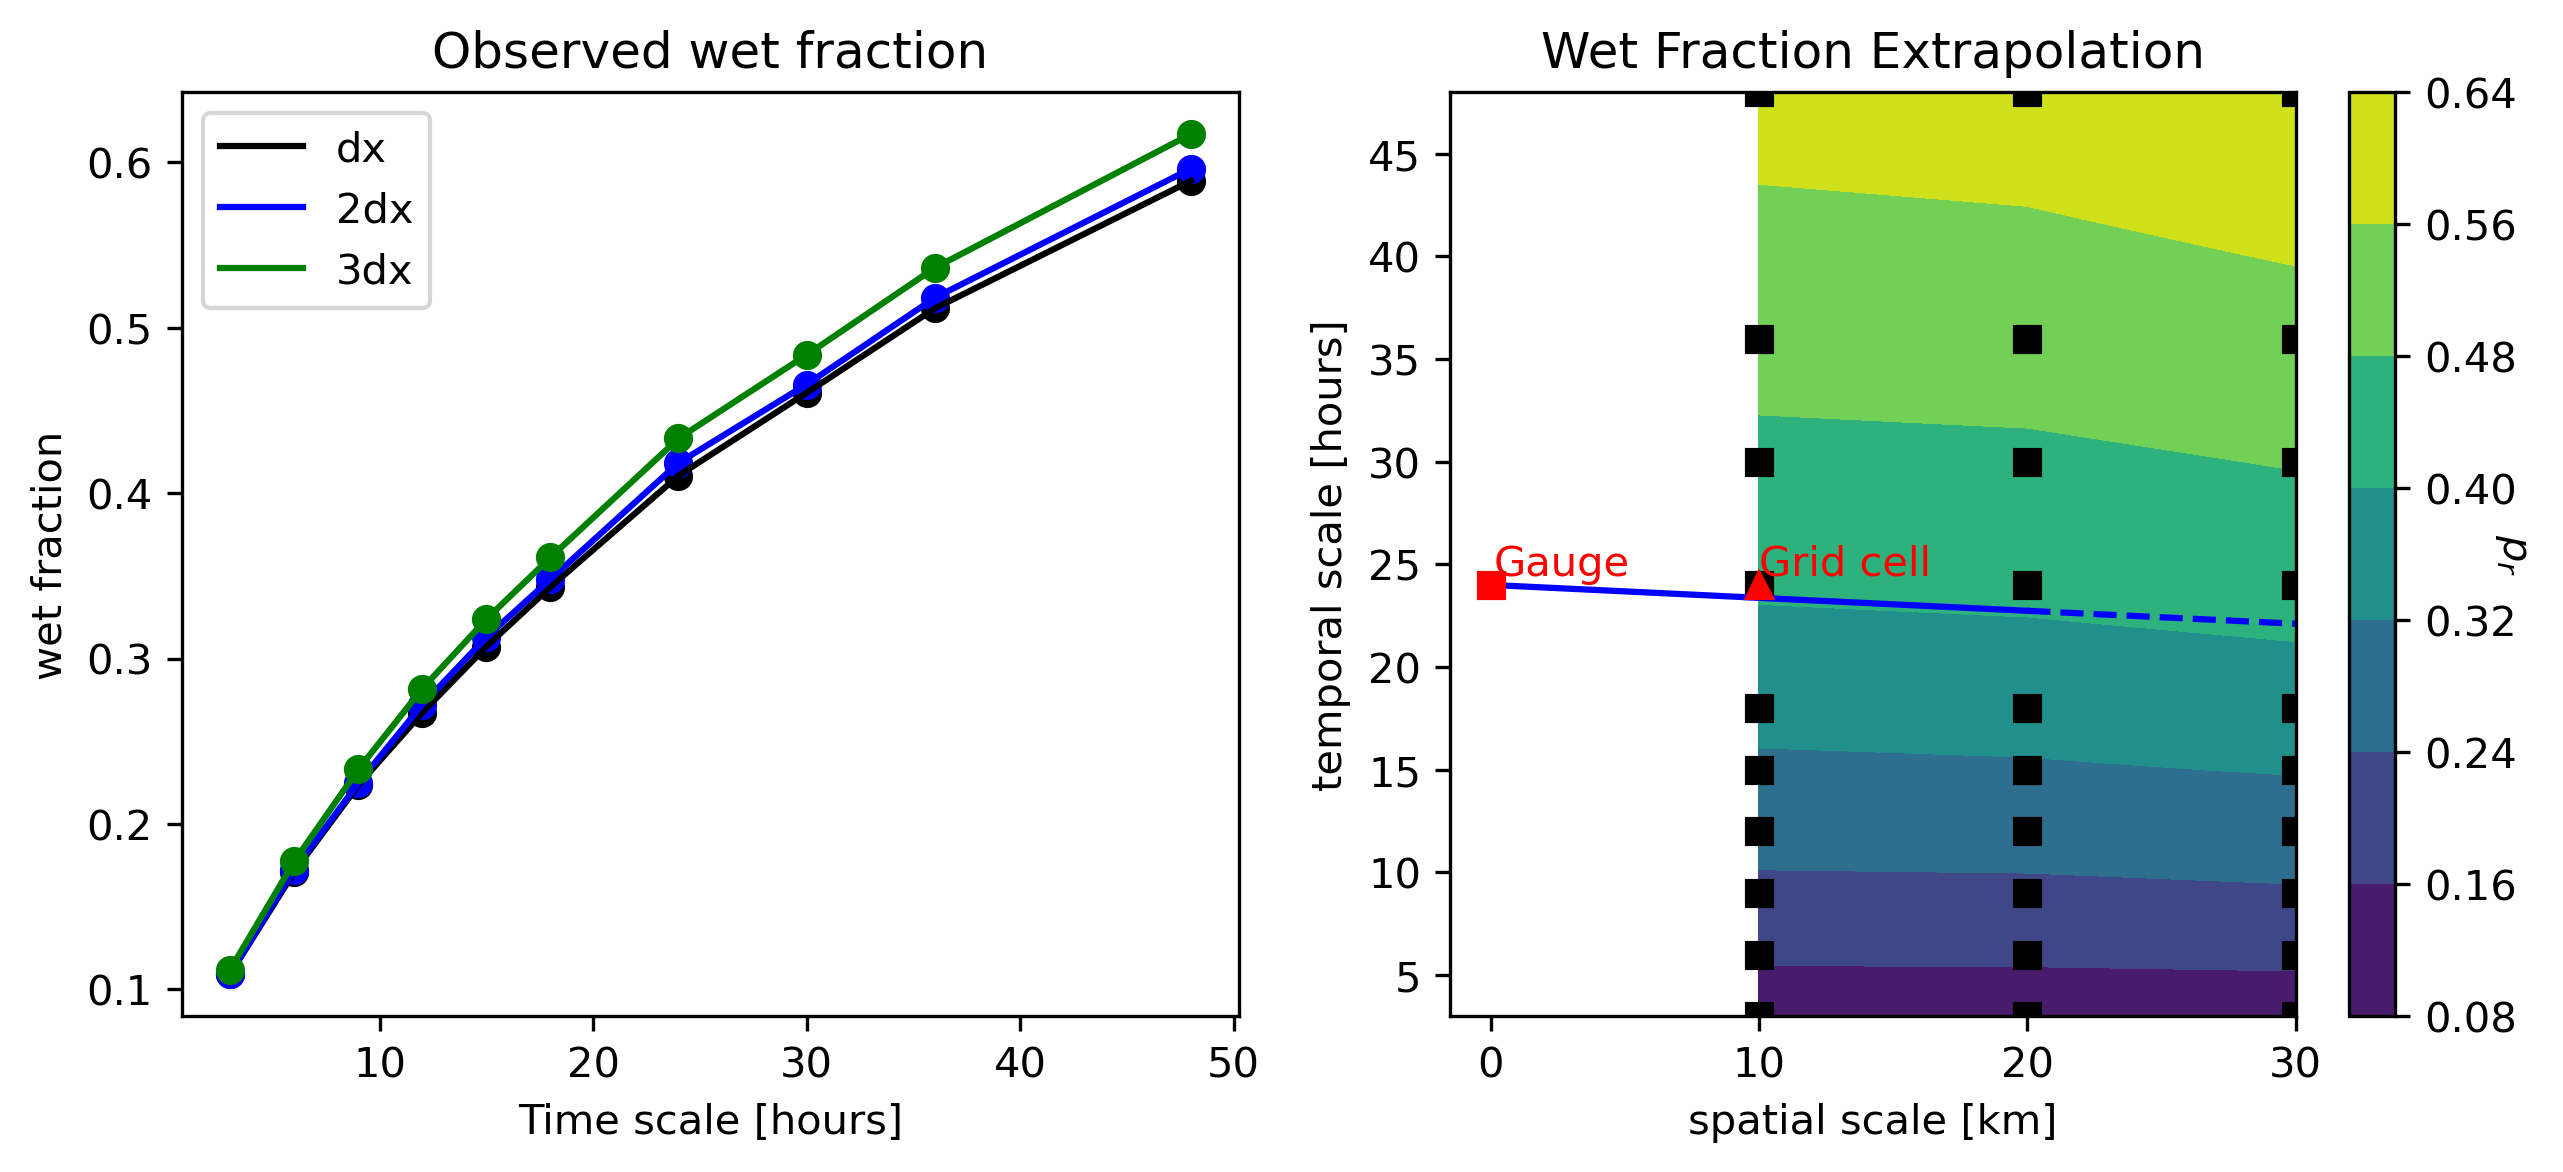

<Figure size 640x480 with 0 Axes>

In [470]:
fig = plt.figure(figsize=(10,4),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(tscales, pwets[:,0], 'ok')
ax1.plot(tscales, pwets[:,1], 'ob')
ax1.plot(tscales_int, pwmat_int[:,0], '-k', label = 'dx')
ax1.plot(tscales_int, pwmat_int[:,1], '-b', label = '2dx')
if nxscales > 2:
    ax1.plot(tscales, pwets[:,2], 'og')
    ax1.plot(tscales_int, pwmat_int[:,2], '-g', label = '3dx')
ax1.set_xlabel('Time scale [hours]')
ax1.set_ylabel('wet fraction')
ax1.set_title('Observed wet fraction')
ax1.legend()

# ============================================================
ax1 = plt.subplot(gs[0, 1])
xxx1 = np.linspace(0, 2*L1, 10)
xxx2 = np.linspace(2*L1, 3*L1, 10)
contour = plt.figure()
# PS3 = plt.contourf(dxv, dtv, Nmatv)
PS3 = ax1.contourf(xscales_km, tscales_int, pwmat_int)
cbar = plt.colorbar(PS3)
cbar.set_label(r'$p_r$')
cbar.set_label(r'$p_r$', rotation=270)
for ii in range(nxscales):
    for jj in range(ntscales):
        ax1.plot(xscales_km[ii], tscales[jj], 'sk')
ax1.plot(xxx1, (xxx1 - X0[best_index]) / U[best_index], 'b')
ax1.plot(xxx2, (xxx2 - X0[best_index]) / U[best_index], '--b')
ax1.plot(target_x, target_t, 'sr')
ax1.plot(origin_x, origin_t, '^r')
ax1.set_xlabel('spatial scale [km]')
ax1.set_ylabel('temporal scale [hours]')
ax1.set_title('Wet Fraction Extrapolation')
ax1.text(0.1, 24.5, 'Gauge', color='red')
ax1.text(L1, 24.5, 'Grid cell', color='red')

In [241]:
parnames = ['eps', 'alp'] if acf == 'mar' else ['d0', 'mu0']

## Correlation downscaling

In [471]:
rcorr = down.grid_corr(xdaily, plot=True, thresh=thresh)
gam_s = down.vrf(L1, L0, (rcorr['{}_s'.format(parnames[0])],
                        rcorr['{}_s'.format(parnames[1])]), acf=acf)

dcorr =  down.down_corr(rcorr['vdist'], rcorr['vcorr'], L1, acf=acf,
                    use_ave=True, opt_method='genetic', toll=0.005,
                    plot=True)

differential_evolution step 1: f(x)= 0.00040883636080413715
differential_evolution step 2: f(x)= 0.00040883636080413715
differential_evolution step 3: f(x)= 0.00040883636080413715
Polishing solution with 'L-BFGS-B'
integration domain is zero


## downscaling the Weibull pdf

In [472]:
print('Downscaling pdf - global Weibull parameters')
par_acf = (dcorr['{}_d'.format(parnames[0])], dcorr['{}_d'.format(parnames[1])])

Nd, Cd, Wd, gam_d, fval_w = down.down_wei(Ns, Cs, Ws, L1, L0, beta, par_acf, acf=acf)

print('Downscaling pdf - yearly Weibull parameters')
NCWy, YEARSy = down.fit_yearly_weibull(tsc, thresh=thresh, maxmiss=100)
NYd, CYd, WYd, _, _ = down.down_wei(NCWy[:,0], NCWy[:,1], NCWy[:,2], L1, L0, beta, par_acf, acf=acf)

Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters


In [473]:
res['NYs'] = NCWy[:,0] # yearly Weibull parameters
res['CYs'] = NCWy[:,1] # yearly Weibull parameters
res['WYs'] = NCWy[:,2] # yearly Weibull parameters
res['NYd'] = NYd # Nd, Cd, Wd (downscaled parameters)
res['CYd'] = CYd # Nd, Cd, Wd (downscaled parameters)
res['WYd'] = WYd # Nd, Cd, Wd (downscaled parameters)

In [475]:
Tr = np.array([10, 20, 50, 100]) # pass
Fi = 1-1/Tr
res['Tr'] = Tr
# x0 = 150.0
x0 = 9.0*np.mean(CYd)
res['mev_d'] = down.mev_quant(Fi, x0, NYd, CYd, WYd, thresh=thresh)[0] # Computes the MEV quantile for given non exceedance probability
res['mev_s'] = down.mev_quant(Fi, x0, NCWy[:,0], NCWy[:,1], NCWy[:,2],thresh=thresh)[0] # Computes the MEV quantile for given non exceedance probability

res['gam_d'] = gam_d # variance reduction function downscale
res['gam_s'] = gam_s # variance reduction factor
res['beta'] = beta # ratio between pwet at the grid cell scale () to pwet at the target subgrid scale ()
res['Nd'] = Nd # Nd, Cd, Wd (downscaled parameters)
res['Cd'] = Cd # Nd, Cd, Wd (downscaled parameters)
res['Wd'] = Wd # Nd, Cd, Wd (downscaled parameters)
res['Ns'] = Ns # global Weibull parameters
res['Cs'] = Cs # global Weibull parameters
res['Ws'] = Ws # global Weibull parameters
res['{}_s'.format(parnames[0])] = rcorr['{}_s'.format(parnames[0])]
res['{}_s'.format(parnames[1])] = rcorr['{}_s'.format(parnames[1])]
res['{}_d'.format(parnames[0])] = dcorr['{}_d'.format(parnames[0])]
res['{}_d'.format(parnames[1])] = dcorr['{}_d'.format(parnames[1])]
res['corr_down_success'] =        dcorr['success']
res['corr_down_funval'] =         dcorr['funval']
res['w_down_funval'] = fval_w[0] # function value at the end of numerical minimization
res['thresh'] = thresh # threshold used in the analysis
res['clat'] = clat
res['clon'] = clon

In [479]:
YEARS = np.copy(YEARS_1dy)

In [481]:
NCW

(5195, 3.5266324040502925, 0.6870189079637671)

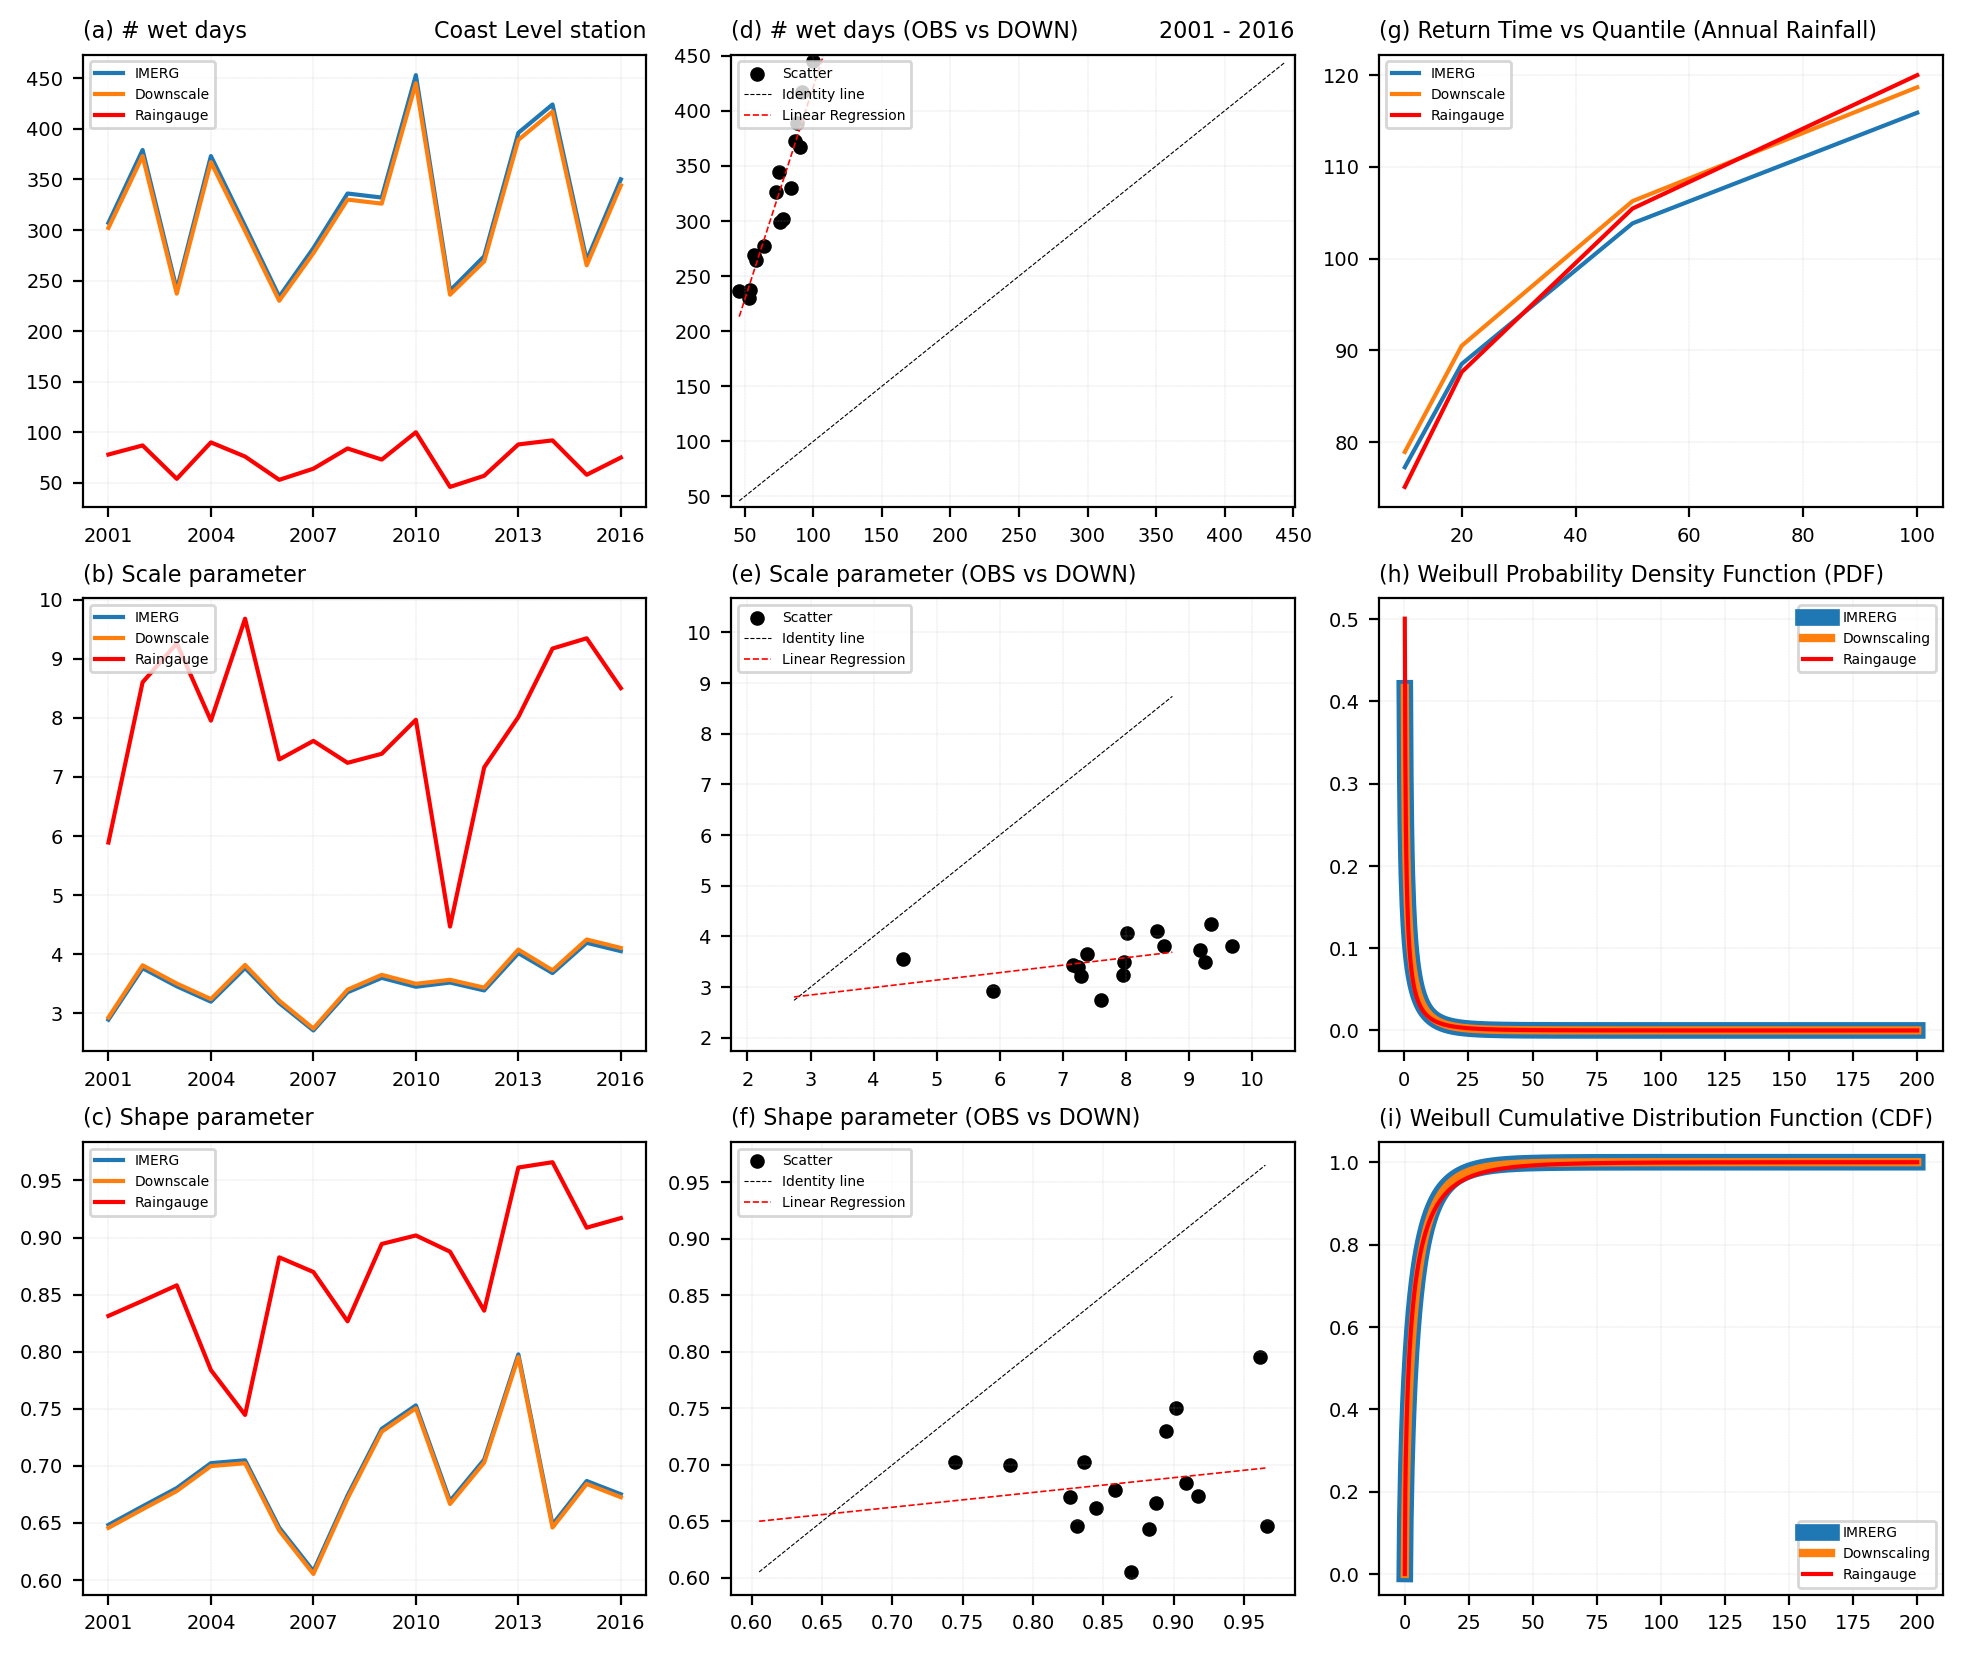

In [486]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(12,10),dpi=200)
gs = gridspec.GridSpec(3,3)

# ============================================================================================================================
# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0])

ax1.plot(YEARS, res['NYs'], label='IMERG')
ax1.plot(YEARS, res['NYd'], label='Downscale')
ax1.plot(YEARS, NCW_1dy[:,0], c='r', label='Raingauge')

ax1.legend(fontsize=5, loc=2)
ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xticks(YEARS.astype(int)[::3])
ax1.set_xticklabels(YEARS.astype(int)[::3])
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.set_title('(a) # wet days', loc='left', fontsize=8)
ax1.set_title(f'{name} station', loc='right', fontsize=8)

# ==============================================================================================
ax1 = plt.subplot(gs[1, 0])

ax1.plot(YEARS, res['CYs'], label='IMERG')
ax1.plot(YEARS, res['CYd'], label='Downscale')
ax1.plot(YEARS, NCW_1dy[:,1], c='r', label='Raingauge')

ax1.legend(fontsize=5, loc=2)
ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xticks(YEARS.astype(int)[::3])
ax1.set_xticklabels(YEARS.astype(int)[::3])
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.set_title('(b) Scale parameter', loc='left', fontsize=8)

# ==============================================================================================
ax1 = plt.subplot(gs[2, 0])

ax1.plot(YEARS, res['WYs'], label='IMERG')
ax1.plot(YEARS, res['WYd'], label='Downscale')
ax1.plot(YEARS, NCW_1dy[:,2], c='r',label='Raingauge')

ax1.legend(fontsize=5, loc=2)
ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xticks(YEARS.astype(int)[::3])
ax1.set_xticklabels(YEARS.astype(int)[::3])
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.set_title('(c) Shape parameter', loc='left', fontsize=8)

# ============================================================================================================================
# ============================================================================================================================
max_ref = np.max((np.max(NCW_1dy[:,0]), np.max(res['NYd'])))
min_ref = np.min((np.min(NCW_1dy[:,0]), np.min(res['NYd'])))
ax1 = plt.subplot(gs[0, 1])

ax1.scatter(NCW_1dy[:,0], res['NYd'], c='k', s=18, label='Scatter')
ax1.plot(np.arange(min_ref,max_ref),np.arange(min_ref,max_ref), '--', color='k', linewidth=0.4, label='Identity line')

slope, intercept, _, _, _ = stats.linregress(NCW_1dy[:,0], res['NYd'])
ax1.plot(np.arange(min_ref,max_ref), slope*np.arange(min_ref,max_ref) + intercept, '--', color='r', linewidth=0.6, label='Linear Regression')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xlim(min_ref-6, max_ref+6)
ax1.set_ylim(min_ref-6, max_ref+6)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=2)
ax1.set_title('(d) # wet days (OBS vs DOWN)', loc='left', fontsize=8)
ax1.set_title(f'{yy_s} - {yy_e}', loc='right', fontsize=8)

# ==============================================================================================
max_ref = np.max((np.max(NCW_1dy[:,1]), np.max(res['CYd'])))
min_ref = np.min((np.min(NCW_1dy[:,1]), np.min(res['CYd'])))
ax1 = plt.subplot(gs[1, 1])

ax1.scatter(NCW_1dy[:,1], res['CYd'], c='k', s=18, label='Scatter')
ax1.plot(np.arange(min_ref,max_ref),np.arange(min_ref,max_ref), '--', color='k', linewidth=0.4, label='Identity line')

slope, intercept, _, _, _ = stats.linregress(NCW_1dy[:,1], res['CYd'])
ax1.plot(np.arange(min_ref,max_ref), slope*np.arange(min_ref,max_ref) + intercept, '--', color='r', linewidth=0.6, label='Linear Regression')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xlim(min_ref-1, max_ref+1)
ax1.set_ylim(min_ref-1, max_ref+1)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=2)
ax1.set_title('(e) Scale parameter (OBS vs DOWN)', loc='left', fontsize=8)

# ==============================================================================================
max_ref = np.max((np.max(NCW_1dy[:,2]), np.max(res['WYd'])))
min_ref = np.min((np.min(NCW_1dy[:,2]), np.min(res['WYd'])))
ax1 = plt.subplot(gs[2, 1])

ax1.scatter(NCW_1dy[:,2], res['WYd'], c='k', s=18, label='Scatter')
ax1.plot(np.arange(min_ref,max_ref, 0.01),np.arange(min_ref,max_ref, 0.01), '--', color='k', linewidth=0.4, label='Identity line')

slope, intercept, _, _, _ = stats.linregress(NCW_1dy[:,2], res['WYd'])
ax1.plot(np.arange(min_ref,max_ref, 0.01), slope*np.arange(min_ref,max_ref, 0.01) + intercept, '--', color='r', linewidth=0.6, label='Linear Regression')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xlim(min_ref-0.02, max_ref+0.02)
ax1.set_ylim(min_ref-0.02, max_ref+0.02)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=2)
ax1.set_title('(f) Shape parameter (OBS vs DOWN)', loc='left', fontsize=8)

# ============================================================================================================================
# ============================================================================================================================
quant, flags = down.mev_quant(Fi, 0, NCW_1dy[:,0], NCW_1dy[:,1], NCW_1dy[:,2], thresh=1)
ax1 = plt.subplot(gs[0, 2])
ax1.plot(Tr, res['mev_s'], label='IMERG')
ax1.plot(Tr, res['mev_d'], label='Downscale')
ax1.plot(Tr, quant, c='r', label='Raingauge')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=2)
ax1.set_title('(g) Return Time vs Quantile (Annual Rainfall)', loc='left', fontsize=8)

# ==============================================================================================
x = np.linspace(0, 200, 1000)
OBS_N, OBS_scale, OBS_shape = down.wei_fit(OBS_1dy_xr.data)
OBS_pdf = weibull_min.pdf(x, OBS_shape, scale=OBS_scale)
IMERG_pdf = weibull_min.pdf(x, res['Ws'], scale=res['Cs'])
DOWN_pdf = weibull_min.pdf(x, res['Wd'], scale=res['Cd'])
ax1 = plt.subplot(gs[1, 2])
ax1.plot(x, IMERG_pdf, linewidth=6, label='IMRERG')
ax1.plot(x, DOWN_pdf, linewidth=3, label='Downscaling')
ax1.plot(x, OBS_pdf,  c='r', label='Raingauge')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=0)
ax1.set_title('(h) Weibull Probability Density Function (PDF)', loc='left', fontsize=8)

# ==============================================================================================
x = np.linspace(0, 200, 1000)
OBS_cdf = weibull_min.cdf(x, OBS_shape, scale=OBS_scale)
IMERG_cdf = weibull_min.cdf(x, res['Ws'], scale=res['Cs'])
DOWN_cdf = weibull_min.cdf(x, res['Wd'], scale=res['Cd'])
ax1 = plt.subplot(gs[2, 2])
ax1.plot(x, IMERG_cdf, linewidth=6, label='IMRERG')
ax1.plot(x, DOWN_cdf, linewidth=3, label='Downscaling')
ax1.plot(x, OBS_cdf,  c='r', label='Raingauge')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=0)
ax1.set_title('(i) Weibull Cumulative Distribution Function (CDF)', loc='left', fontsize=8)
# ============================================================================================================================
# ============================================================================================================================
plt.subplots_adjust(hspace=0.2,wspace=0.15)

Text(0.0, 1.0, '(b) Scale parameter')

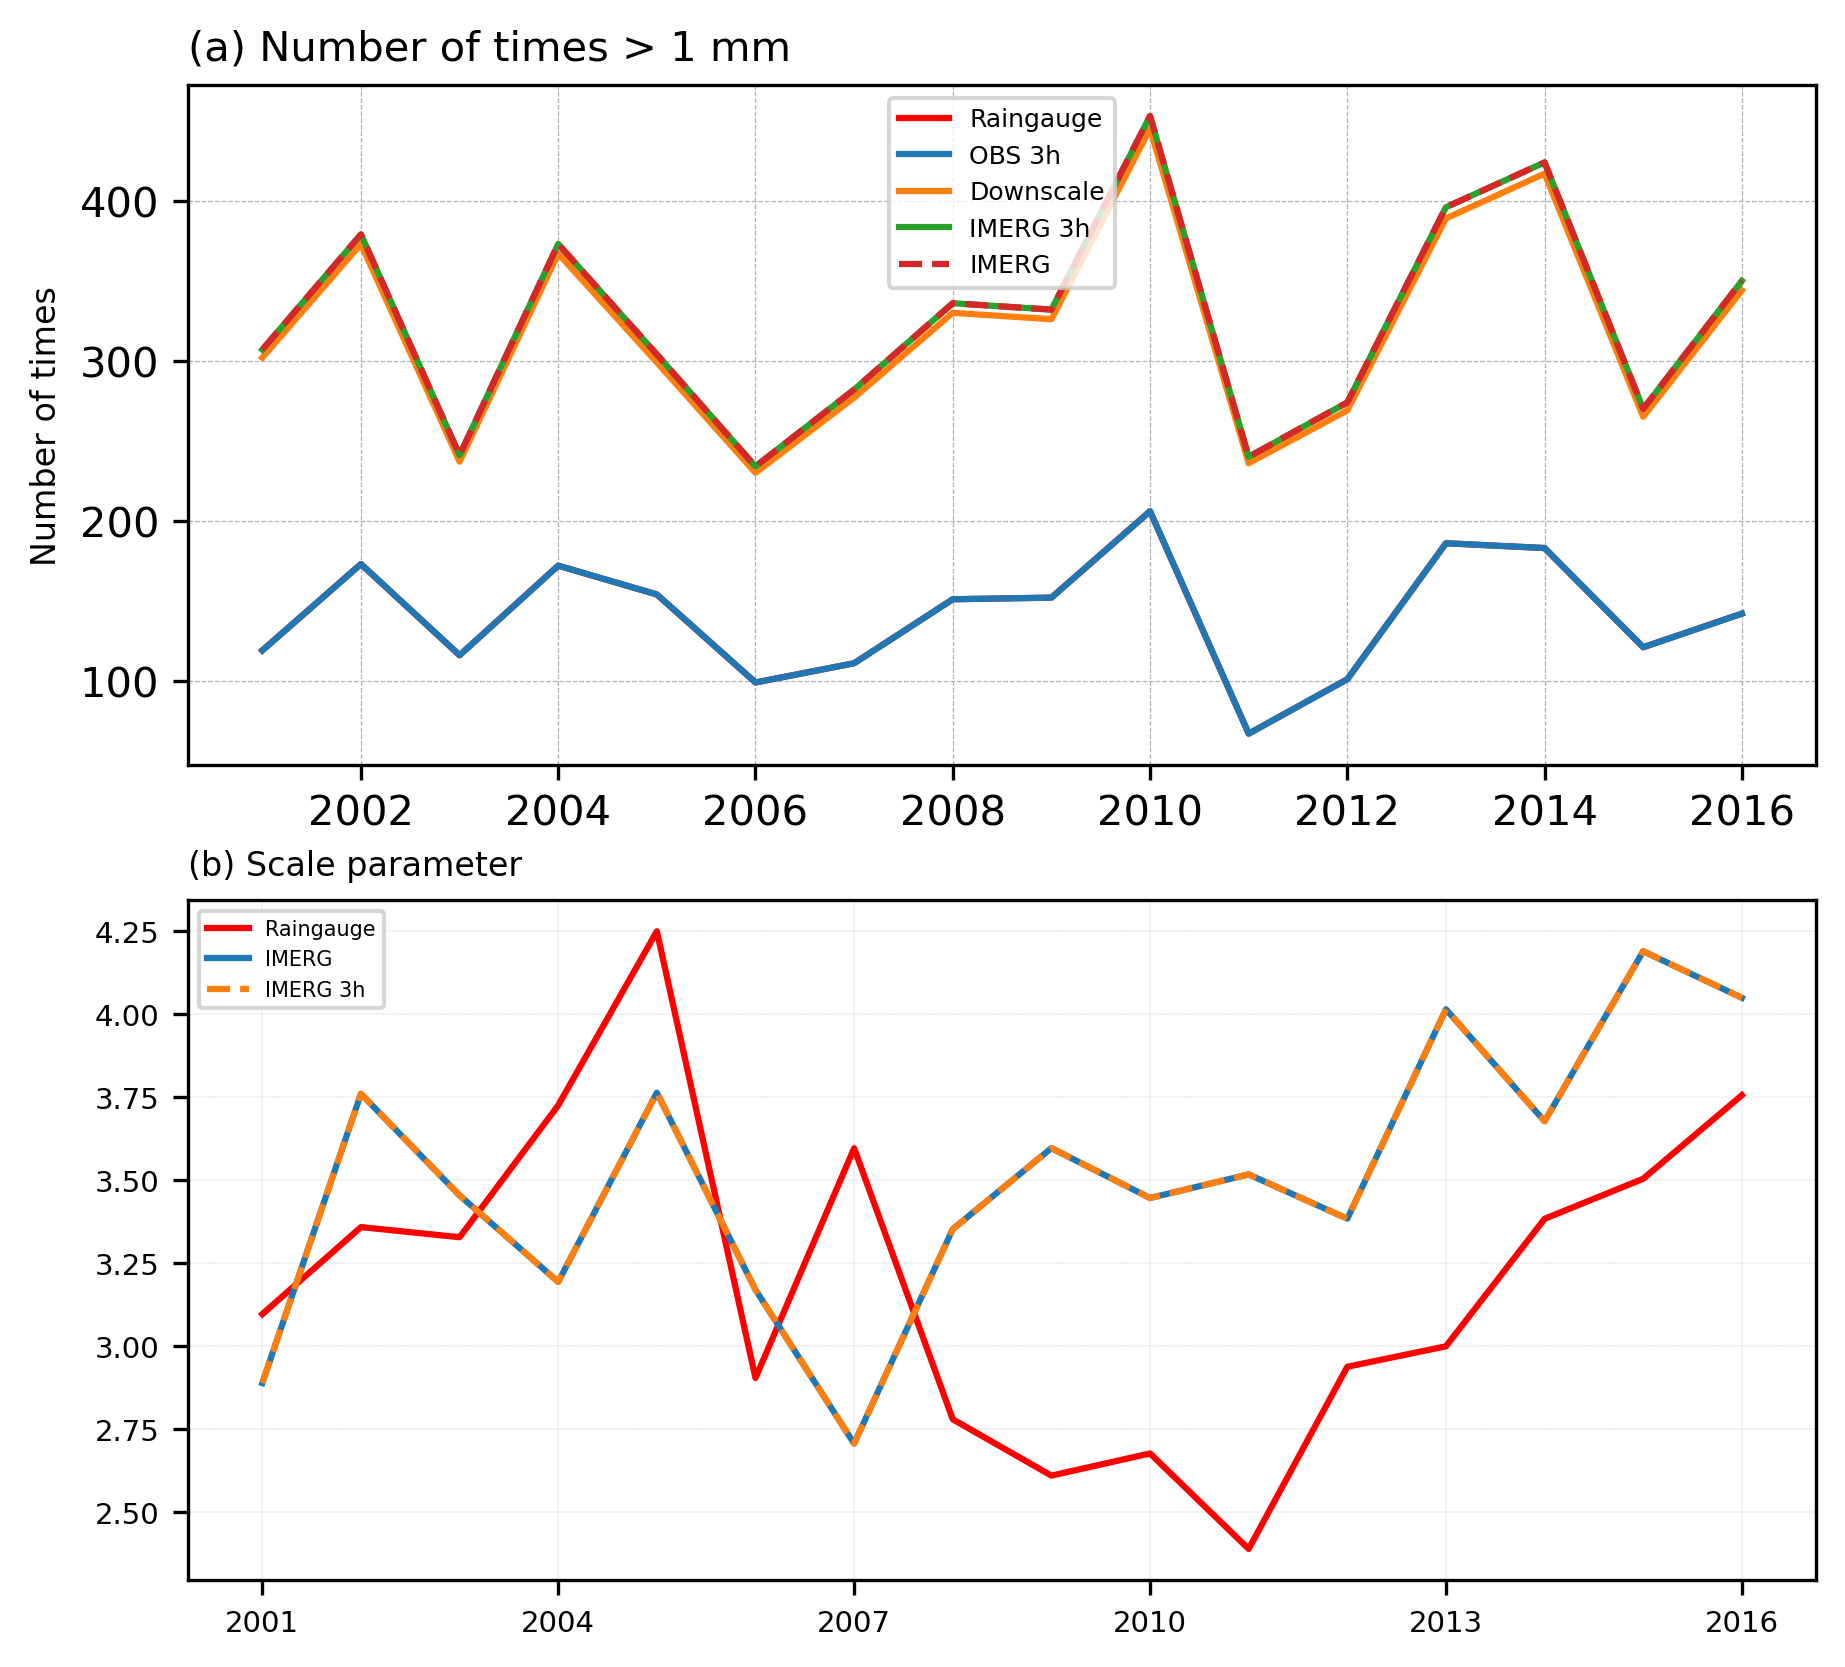

In [511]:
fig = plt.figure(figsize=(7,10),dpi=300)
gs = gridspec.GridSpec(3,1)

# =================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(YEARS, NCW_3h[:,0], c='r', label='Raingauge')
ax1.plot(YEARS_3h, NCW_3h[:,0], label=f'OBS 3h')
ax1.plot(YEARS, res['NYd'], label='Downscale')
ax1.plot(YEARS_IMERG, NCW_IMERG[:,0], label=f'IMERG 3h')
ax1.plot(YEARS, res['NYs'], '--', label='IMERG')
ax1.legend(fontsize=6)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(a) Number of times > 1 mm',loc='left',fontsize=10)
ax1.set_ylabel('Number of times', fontsize=8)

# =================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.plot(YEARS, NCW_3h[:,1], c='r', label='Raingauge')
ax1.plot(YEARS, res['CYs'], label='IMERG')
ax1.plot(YEARS_IMERG, NCW_IMERG[:,1], '--', label=f'IMERG 3h')

ax1.legend(fontsize=5, loc=2)
ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xticks(YEARS.astype(int)[::3])
ax1.set_xticklabels(YEARS.astype(int)[::3])
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.set_title('(b) Scale parameter', loc='left', fontsize=8)
